In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

### Import data

In [118]:
data = pd.read_parquet("~/Desktop/python X/Project/train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


### Data Exploration

#### Summary of data

### Data Preprocessing

In [123]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

problem_title = "Bike count prediction"
_target_column_name = "log_bike_count"
# A type (class) which will be used to create wrapper objects for y_pred


def get_cv(X, y, random_state=0):
    cv = TimeSeriesSplit(n_splits=8)
    rng = np.random.RandomState(random_state)

    for train_idx, test_idx in cv.split(X):
        # Take a random sampling on test_idx so it's that samples are not consecutives.
        yield train_idx, rng.choice(test_idx, size=len(test_idx) // 3, replace=False)


def get_train_data(path="~/Desktop/python X/Project/train.parquet"):
    data = pd.read_parquet(path)
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [125]:
X,y = get_train_data()

In [126]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [129]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


### Gradient Boosting

In [132]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import root_mean_squared_error

target_column = "log_bike_count"

# Define features and target
X_train = X_train.drop(columns=["site_id","counter_id", "counter_technical_id", "counter_installation_date", "coordinates"])
X_valid = X_valid.drop(columns=["site_id","counter_id", "counter_technical_id", "counter_installation_date", "coordinates"])


In [35]:
# Preprocessing for the date column
def encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["hour"] = X["date"].dt.hour
    X["weekday"] = X["date"].dt.weekday
    X["hour_weekday"] = X["hour"] + X["weekday"] * 24  # Interaction term
    return X.drop(columns=["date"])

# Specify columns for preprocessing
date_columns = ["date"]
categorical_columns = ["counter_name", "site_name"]
numeric_columns = ["latitude", "longitude"]

# Define preprocessors
date_encoder = FunctionTransformer(encode_dates)
categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("date", date_encoder, date_columns),
        ("cat", categorical_encoder, categorical_columns),
    ],
    remainder="passthrough"  # Pass through other numeric columns
)

# Create a pipeline with the preprocessor and HistGradientBoostingRegressor
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", HistGradientBoostingRegressor(
        max_iter=100,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        max_depth=5,  # Maximum depth of each tree
        random_state=42,
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.2,  # Fraction of data for validation
        n_iter_no_change=10  # Stop after 10 iterations without improvement
    ))
])

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", HistGradientBoostingRegressor(
        max_iter=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10
    ))
])


# Fit the model
pipe.fit(X_train, y_train)


print(
    f"Gradient Boosting:Train set, RMSE={root_mean_squared_error(y_train, pipe.predict(X_train)):.5f}"
)
print(
    f"Gradient Boosting:Valid set, RMSE={root_mean_squared_error(y_valid, pipe.predict(X_valid)):.5f}"
)

Gradient Boosting:Train set, RMSE=0.59040
Gradient Boosting:Valid set, RMSE=0.55250


### XGBoosting

In [38]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Define the pipeline
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),  # Use the same preprocessor as before
    ("regressor", XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit the model
xgb_pipe.fit(X_train, y_train)

# Evaluate Train and Validation RMSE
print(
    f"XGBoost:Train set, RMSE={mean_squared_error(y_train, xgb_pipe.predict(X_train), squared=False):.5f}"
)
print(
    f"XGBoost:Valid set, RMSE={mean_squared_error(y_valid, xgb_pipe.predict(X_valid), squared=False):.5f}"
)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost:Train set, RMSE=0.59278
XGBoost:Valid set, RMSE=0.56665


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Parameter Tuning

In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the date encoding function
def encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["hour"] = X["date"].dt.hour
    X["weekday"] = X["date"].dt.weekday
    X["hour_weekday"] = X["hour"] + X["weekday"] * 24  # Interaction term
    return X.drop(columns=["date"])

# Define preprocessors
date_encoder = FunctionTransformer(encode_dates)
categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ("date", date_encoder, ["date"]),
        ("cat", categorical_encoder, ["counter_name", "site_name"]),
    ],
    remainder="passthrough"
)

# Define the pipeline
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, n_jobs=-1))
])

# Define the parameter grid for tuning
param_distributions = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "regressor__max_depth": [3, 5, 7, 10],
    "regressor__min_child_weight": [1, 3, 5],
    "regressor__subsample": [0.6, 0.8, 1.0],
    "regressor__colsample_bytree": [0.6, 0.8, 1.0],
    "regressor__gamma": [0, 0.1, 0.2, 0.3]
}

# Use RandomizedSearchCV for tuning
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random samples to try
    cv=3,  # 3-fold cross-validation
    scoring="neg_root_mean_squared_error",  # Metric for evaluation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model with randomized search
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate RMSE for Train and Validation sets
print(
    f"Train set, RMSE={mean_squared_error(y_train, best_model.predict(X_train), squared=False):.5f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, best_model.predict(X_valid), squared=False):.5f}"
)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'regressor__subsample': 1.0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 3, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.2, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 0.6}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train set, RMSE=0.44778
Valid set, RMSE=0.45905


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
# Extract the best parameters
best_params = random_search.best_params_

# Train the model with the best parameters
final_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        subsample=best_params['regressor__subsample'],
        n_estimators=best_params['regressor__n_estimators'],
        min_child_weight=best_params['regressor__min_child_weight'],
        max_depth=best_params['regressor__max_depth'],
        learning_rate=best_params['regressor__learning_rate'],
        gamma=best_params['regressor__gamma'],
        colsample_bytree=best_params['regressor__colsample_bytree'],
        random_state=42,
        n_jobs=-1
    ))
])

# Fit the model on the full training set
final_model.fit(X_train, y_train)

# Evaluate RMSE for Train and Validation sets
train_rmse = mean_squared_error(y_train, final_model.predict(X_train), squared=False)
valid_rmse = mean_squared_error(y_valid, final_model.predict(X_valid), squared=False)

print(f"Final Model - Train set RMSE: {train_rmse:.5f}")
print(f"Final Model - Valid set RMSE: {valid_rmse:.5f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Final Model - Train set RMSE: 0.44778
Final Model - Valid set RMSE: 0.45905


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Analysis Residual

#### Hyperparameter Optimization

In [44]:
import optuna
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
    }

    # Create a pipeline with the suggested parameters
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor(random_state=42, **params))
    ])
    
    # Fit and evaluate
    pipe.fit(X_train, y_train)
    y_valid_pred = pipe.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    return rmse

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Display the best parameters
print("Best parameters:", study.best_params)

# Train the model with the best parameters
best_params = study.best_params
final_xg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, **best_params))
])
final_xg_model.fit(X_train, y_train)

# Evaluate Train and Validation RMSE
train_rmse = mean_squared_error(y_train, final_xg_model.predict(X_train), squared=False)
valid_rmse = mean_squared_error(y_valid, final_xg_model.predict(X_valid), squared=False)

print(f"Final XGboost Model - Train RMSE: {train_rmse:.5f}")
print(f"Final XGboost Model - Validation RMSE: {valid_rmse:.5f}")


[I 2024-12-04 18:59:16,801] A new study created in memory with name: no-name-907f39f2-6d70-4a93-8ad8-1088773c41e9
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 18:59:39,584] Trial 0 finished with value: 0.7014151675919814 and parameters: {'n_estimators': 221, 'learning_rate': 0.011496771849220207, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.9992165086779672, 'colsample_bytree': 0.9546986972188404, 'gamma': 0.32784110209119055}. Best is trial 0 with value: 0.7014151675919814.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 

[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.2, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=200, regressor__subsample=1.0; total time= 1.3min
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__min_child_weight=1, regressor__n_estimators=300, regressor__subsample=0.8; total time= 1.6min
[CV] END regressor__colsample_bytree=0.8, regressor__gamma=0.3, regressor__learning_rate=0.05, regressor__max_depth=5, regressor__min_child_weight=3, regressor__n_estimators=200, regressor__subsample=0.6; total time= 1.0min
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__min_child_weight=5, regressor__n_estimators=200, regressor__subsample=0.8; total time=  50.0s
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.2, regressor__m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 19:03:40,323] Trial 7 finished with value: 0.43130882117076735 and parameters: {'n_estimators': 344, 'learning_rate': 0.19394809152242892, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9102576460348326, 'colsample_bytree': 0.6361234593080416, 'gamma': 0.02846297167963341}. Best is trial 7 with value: 0.43130882117076735.


[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.2, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=200, regressor__subsample=1.0; total time= 1.3min
[CV] END regressor__colsample_bytree=1.0, regressor__gamma=0.2, regressor__learning_rate=0.01, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=300, regressor__subsample=0.8; total time= 2.5min
[CV] END regressor__colsample_bytree=0.8, regressor__gamma=0.2, regressor__learning_rate=0.2, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=200, regressor__subsample=0.6; total time=  48.7s
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.2, regressor__max_depth=3, regressor__min_child_weight=3, regressor__n_estimators=200, regressor__subsample=0.8; total time=  48.5s
[CV] END regressor__colsample_bytree=0.8, regressor__gamma=0.1, regressor__learning_rate=0.1, regressor__

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 19:04:04,218] Trial 8 finished with value: 0.5430810706870485 and parameters: {'n_estimators': 428, 'learning_rate': 0.13390952729671604, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8225476007101005, 'colsample_bytree': 0.9427327151785636, 'gamma': 0.375045704368643}. Best is trial 7 with value: 0.43130882117076735.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 19:04:21,377] Trial 9 finished with value: 0.5367187065134692 and parameters: {'n_estimators': 159, 'learning_rate':

Best parameters: {'n_estimators': 384, 'learning_rate': 0.1665558870680518, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6013312923182433, 'colsample_bytree': 0.7003763379123777, 'gamma': 0.2935350533643978}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Final XGboost Model - Train RMSE: 0.32372
Final XGboost Model - Validation RMSE: 0.41540


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
final_xg_model.fit(X_train, y_train)

# Evaluate Train and Validation RMSE
train_rmse = mean_squared_error(y_train, final_xg_model.predict(X_train), squared=False)
valid_rmse = mean_squared_error(y_valid, final_xg_model.predict(X_valid), squared=False)

print(f"Final XGboost Model - Train RMSE: {train_rmse:.5f}")
print(f"Final XGboost Model - Validation RMSE: {valid_rmse:.5f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Final XGboost Model - Train RMSE: 0.32372
Final XGboost Model - Validation RMSE: 0.41540


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Analyze Residuals

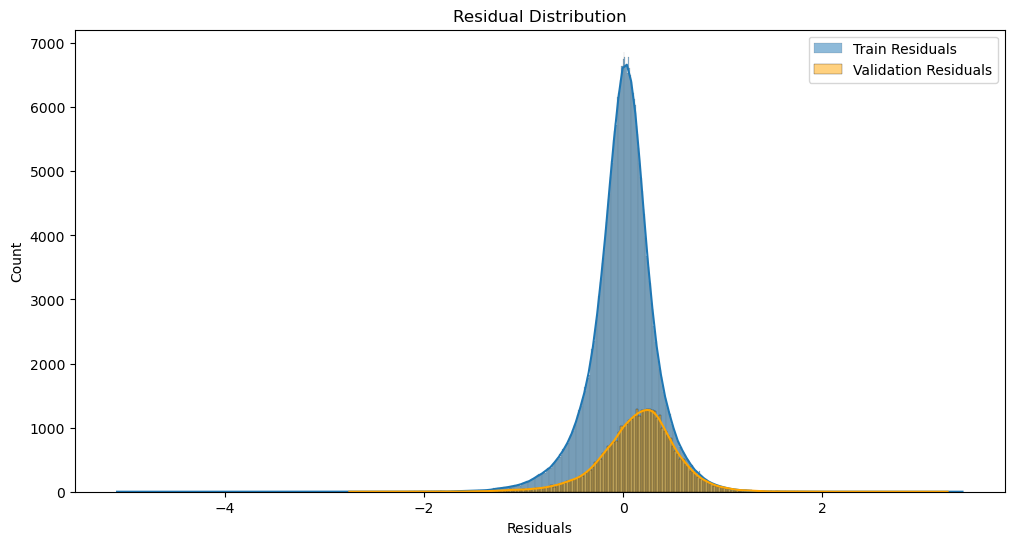

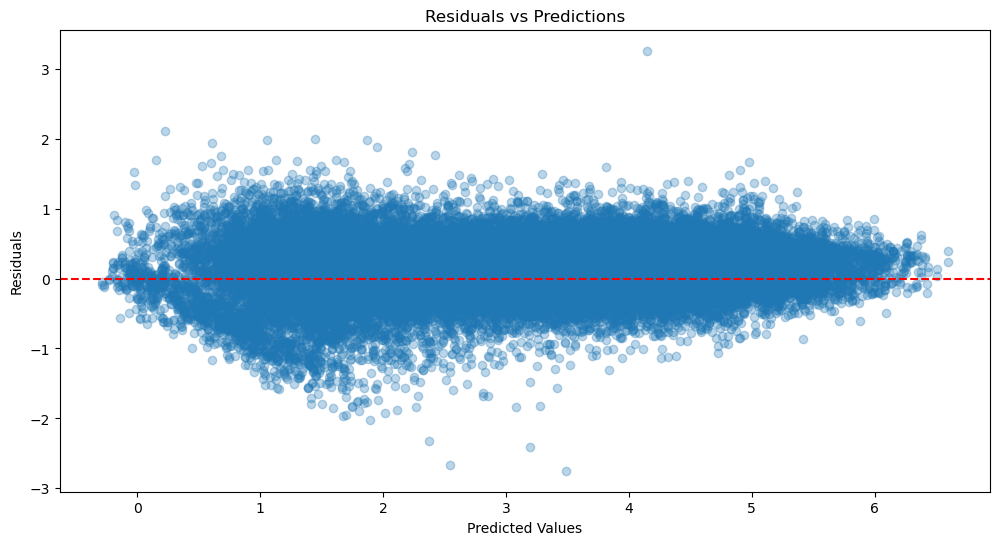

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
train_residuals = y_train - final_xg_model.predict(X_train)
valid_residuals = y_valid - final_xg_model.predict(X_valid)

# Plot residual distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_residuals, kde=True, label="Train Residuals")
sns.histplot(valid_residuals, kde=True, label="Validation Residuals", color="orange")
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.legend()
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(12, 6))
plt.scatter(final_model.predict(X_valid), valid_residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


### CatBoost

In [49]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Function to preprocess date
def preprocess_datetime(data):
    data = data.copy()
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["hour"] = data["date"].dt.hour
    data["weekday"] = data["date"].dt.weekday
    data["hour_weekday"] = data["hour"] + data["weekday"] * 24  # Interaction term
    return data.drop(columns=["date"])  # Drop the original datetime column

# Apply preprocessing to the train and validation datasets
X_train_preprocessed = preprocess_datetime(X_train)
X_valid_preprocessed = preprocess_datetime(X_valid)

# Specify categorical feature indices (relative to preprocessed data)
categorical_features = ["counter_name", "site_name"]
cat_features_indices = [X_train_preprocessed.columns.get_loc(col) for col in categorical_features]

# Train CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=5,
    random_seed=42,
    cat_features=cat_features_indices,
    verbose=100
)
cat_model.fit(
    X_train_preprocessed, y_train,
    eval_set=(X_valid_preprocessed, y_valid),
    early_stopping_rounds=50
)

# Evaluate Train and Validation RMSE
train_rmse = mean_squared_error(y_train, cat_model.predict(X_train_preprocessed), squared=False)
valid_rmse = mean_squared_error(y_valid, cat_model.predict(X_valid_preprocessed), squared=False)

print(f"CatBoost - Train set, RMSE={train_rmse:.5f}")
print(f"CatBoost - Valid set, RMSE={valid_rmse:.5f}")


0:	learn: 1.5795171	test: 1.4014513	best: 1.4014513 (0)	total: 259ms	remaining: 4m 19s
100:	learn: 0.6576507	test: 0.5993405	best: 0.5993405 (100)	total: 10.7s	remaining: 1m 34s
200:	learn: 0.5867369	test: 0.5405326	best: 0.5405326 (200)	total: 22.6s	remaining: 1m 29s
300:	learn: 0.5494077	test: 0.5114228	best: 0.5114228 (300)	total: 33.5s	remaining: 1m 17s
400:	learn: 0.5261097	test: 0.4923687	best: 0.4923687 (400)	total: 45.2s	remaining: 1m 7s
500:	learn: 0.5071449	test: 0.4831755	best: 0.4831755 (500)	total: 56.6s	remaining: 56.4s
600:	learn: 0.4937009	test: 0.4740466	best: 0.4739527 (599)	total: 1m 8s	remaining: 45.7s
700:	learn: 0.4842273	test: 0.4683262	best: 0.4683262 (700)	total: 1m 20s	remaining: 34.3s
800:	learn: 0.4762151	test: 0.4629242	best: 0.4628485 (797)	total: 1m 31s	remaining: 22.8s
900:	learn: 0.4692318	test: 0.4563351	best: 0.4563240 (899)	total: 1m 45s	remaining: 11.6s
999:	learn: 0.4630064	test: 0.4541638	best: 0.4541638 (999)	total: 1m 56s	remaining: 0us

bestTes

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [50]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Suggest hyperparameters for CatBoost
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # Only add `subsample` if bootstrap type is not Bayesian
    if params["bootstrap_type"] != "Bayesian":
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)

    # Add bagging temperature for Bayesian bootstrap
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

    # Create and train the CatBoost model
    model = CatBoostRegressor(
        cat_features=cat_features_indices,
        random_seed=42,
        verbose=0,
        **params
    )
    model.fit(X_train_preprocessed, y_train, eval_set=(X_valid_preprocessed, y_valid), early_stopping_rounds=50)

    # Calculate RMSE for validation set
    valid_rmse = mean_squared_error(y_valid, model.predict(X_valid_preprocessed), squared=False)
    return valid_rmse

# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=3600)  # Run 50 trials or stop after 1 hour

# Display the best parameters and RMSE
print("Best parameters:", study.best_params)
print(f"Best Validation RMSE: {study.best_value:.5f}")

# Train final model with the best parameters
best_params = study.best_params
final_cat_model = CatBoostRegressor(
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=100,
    **best_params
)
final_cat_model.fit(X_train_preprocessed, y_train, eval_set=(X_valid_preprocessed, y_valid), early_stopping_rounds=50)

# Evaluate Train and Validation RMSE
train_rmse = mean_squared_error(y_train, final_cat_model.predict(X_train_preprocessed), squared=False)
valid_rmse = mean_squared_error(y_valid, final_cat_model.predict(X_valid_preprocessed), squared=False)

print(f"Final CatBoost Model - Train RMSE: {train_rmse:.5f}")
print(f"Final CatBoost Model - Validation RMSE: {valid_rmse:.5f}")


[I 2024-12-04 19:19:15,822] A new study created in memory with name: no-name-adf261f8-4458-4c26-b87e-05fcdfcac2d7
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 19:22:14,851] Trial 0 finished with value: 0.44040994019521873 and parameters: {'iterations': 697, 'learning_rate': 0.18569060363180373, 'depth': 9, 'l2_leaf_reg': 1.5138128407878848, 'random_strength': 6.34536371933144, 'bootstrap_type': 'MVS', 'subsample': 0.9655451663037415}. Best is trial 0 with value: 0.44040994019521873.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-04 1

Best parameters: {'iterations': 927, 'learning_rate': 0.23853023400691165, 'depth': 9, 'l2_leaf_reg': 5.996954877117027, 'random_strength': 1.8456251785298243, 'bootstrap_type': 'MVS', 'subsample': 0.6011541483478536}
Best Validation RMSE: 0.43672
0:	learn: 1.4130337	test: 1.2421619	best: 1.2421619 (0)	total: 218ms	remaining: 3m 22s
100:	learn: 0.4523980	test: 0.4616646	best: 0.4616646 (100)	total: 22.1s	remaining: 3m
200:	learn: 0.4066136	test: 0.4411392	best: 0.4406611 (199)	total: 44.5s	remaining: 2m 40s
300:	learn: 0.3843263	test: 0.4368253	best: 0.4368253 (300)	total: 1m 6s	remaining: 2m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4367184473
bestIteration = 308

Shrink model to first 309 iterations.
Final CatBoost Model - Train RMSE: 0.38103
Final CatBoost Model - Validation RMSE: 0.43672


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Feature Importance

      Feature Id  Importances
0           hour    52.344962
1          month    14.692249
2      site_name     9.904705
3   counter_name     5.743343
4        site_id     5.007553
5   hour_weekday     4.166312
6            day     2.915155
7      longitude     2.249986
8       latitude     1.610362
9        weekday     0.773208
10          year     0.592165


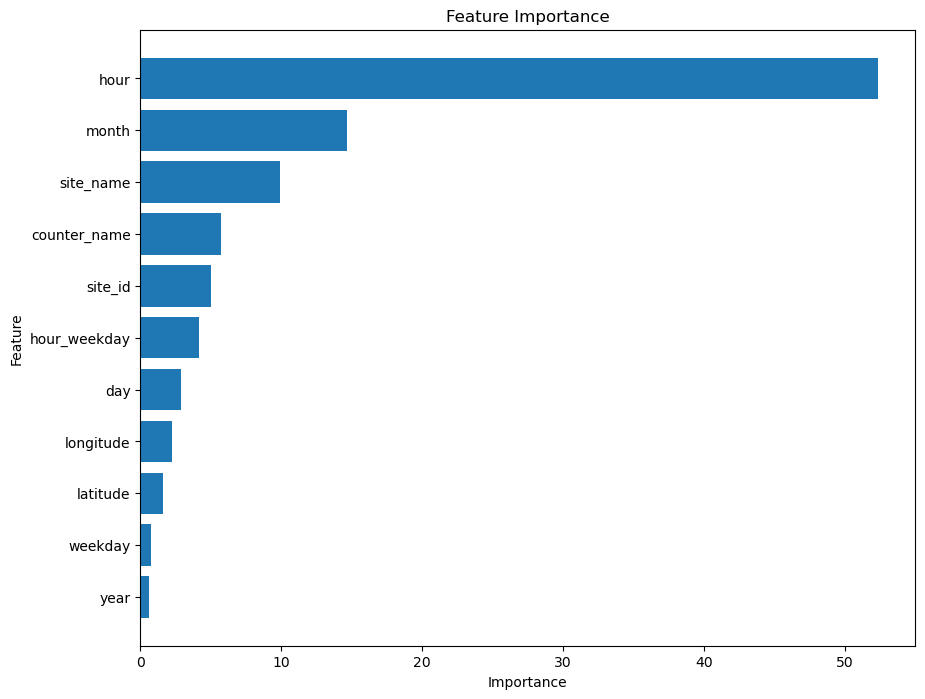

In [53]:
import matplotlib.pyplot as plt
feature_importances = cat_model.get_feature_importance(prettified=True)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances["Feature Id"], feature_importances["Importances"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


### Stacking(Catboost and Xgboost)

In [55]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [56]:
final_cat_model.fit(X_train_preprocessed, y_train, eval_set=(X_valid_preprocessed, y_valid), early_stopping_rounds=50)
final_cat_model.predict(X_valid_preprocessed)

final_xg_model.fit(X_train, y_train)
final_xg_model.predict(X_valid)

0:	learn: 1.4130337	test: 1.2421619	best: 1.2421619 (0)	total: 238ms	remaining: 3m 39s
100:	learn: 0.4523980	test: 0.4616646	best: 0.4616646 (100)	total: 21.8s	remaining: 2m 57s
200:	learn: 0.4066136	test: 0.4411392	best: 0.4406611 (199)	total: 43.7s	remaining: 2m 37s
300:	learn: 0.3843263	test: 0.4368253	best: 0.4368253 (300)	total: 1m 4s	remaining: 2m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4367184473
bestIteration = 308

Shrink model to first 309 iterations.


array([1.2610207 , 1.0884482 , 0.95070416, ..., 3.1288133 , 2.3477006 ,
       2.3439925 ], dtype=float32)

In [57]:
cat_preds = final_cat_model.predict(X_valid_preprocessed)
xgb_preds = final_xg_model.predict(X_valid)

In [58]:
# Combine predictions as features for stacking
stacked_features_full = np.vstack((cat_preds, xgb_preds)).T

# Split stacked features for meta-model training and validation
X_train_meta, X_valid_meta, y_train_meta, y_valid_meta = train_test_split(
    stacked_features_full, y_valid, test_size=0.2, random_state=42
)

# Train the Ridge regression model as the meta-model
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_train_meta, y_train_meta)

# Predict on the validation meta-set
meta_preds = meta_model.predict(X_valid_meta)

# Calculate and print the RMSE for the stacked model
meta_rmse = mean_squared_error(y_valid_meta, meta_preds, squared=False)
print(f"Stacked Ensemble Model - Validation RMSE: {meta_rmse:.5f}")

Stacked Ensemble Model - Validation RMSE: 0.38607


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Hyperparameters Tuning

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a simple neural network
meta_nn = Sequential([
    Dense(64, activation="relu", input_shape=(stacked_features_full.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)
])
meta_nn.compile(optimizer="adam", loss="mse")

# Train the neural network
meta_nn.fit(X_train_meta, y_train_meta, epochs=50, batch_size=16, validation_data=(X_valid_meta, y_valid_meta), verbose=2)

# Predict and calculate RMSE
meta_nn_preds = meta_nn.predict(X_valid_meta).flatten()
meta_nn_rmse = mean_squared_error(y_valid_meta, meta_nn_preds, squared=False)
print(f"Neural Network Meta-Model - Validation RMSE: {meta_nn_rmse:.5f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2016/2016 - 6s - 3ms/step - loss: 0.2151 - val_loss: 0.1491
Epoch 2/50
2016/2016 - 5s - 2ms/step - loss: 0.1505 - val_loss: 0.1498
Epoch 3/50
2016/2016 - 5s - 2ms/step - loss: 0.1501 - val_loss: 0.1495
Epoch 4/50
2016/2016 - 4s - 2ms/step - loss: 0.1496 - val_loss: 0.1497
Epoch 5/50
2016/2016 - 5s - 2ms/step - loss: 0.1490 - val_loss: 0.1504
Epoch 6/50
2016/2016 - 4s - 2ms/step - loss: 0.1491 - val_loss: 0.1503
Epoch 7/50
2016/2016 - 5s - 2ms/step - loss: 0.1490 - val_loss: 0.1516
Epoch 8/50
2016/2016 - 4s - 2ms/step - loss: 0.1485 - val_loss: 0.1526
Epoch 9/50
2016/2016 - 4s - 2ms/step - loss: 0.1488 - val_loss: 0.1497
Epoch 10/50
2016/2016 - 4s - 2ms/step - loss: 0.1488 - val_loss: 0.1510
Epoch 11/50
2016/2016 - 3s - 2ms/step - loss: 0.1485 - val_loss: 0.1524
Epoch 12/50
2016/2016 - 4s - 2ms/step - loss: 0.1484 - val_loss: 0.1567
Epoch 13/50
2016/2016 - 5s - 3ms/step - loss: 0.1483 - val_loss: 0.1494
Epoch 14/50
2016/2016 - 4s - 2ms/step - loss: 0.1483 - val_loss: 0.1592
E

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [177]:
test = pd.read_parquet("~/Desktop/python X/Project/final_test.parquet")

In [179]:
test.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [181]:
test_data = test.drop(columns=["counter_id", "counter_technical_id", "counter_installation_date", "coordinates"])

In [183]:
test_data

,counter_name,site_id,site_name,date,latitude,longitude
0,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,48.846028,2.375429
1,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,48.846028,2.375429
2,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,48.846028,2.375429
3,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,48.846028,2.375429
4,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,48.846028,2.375429
...,...,...,...,...,...,...
51435,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 11:00:00,48.839770,2.301980
51436,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 15:00:00,48.839770,2.301980
51437,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 17:00:00,48.839770,2.301980
51438,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 18:00:00,48.839770,2.301980


In [185]:
X_test_preprocessed = preprocess_datetime(test_data)

In [187]:
# Prepare CatBoost Pool for prediction
cat_features_indices = [X_test_preprocessed.columns.get_loc(col) for col in categorical_columns]  # Indices of categorical columns
test_pool = Pool(data=X_test_preprocessed, cat_features=cat_features_indices)

In [189]:
categorical_columns

['counter_name', 'site_name']

In [191]:
from catboost import Pool

# Prepare CatBoost Pool for prediction
cat_features_indices = [X_test_preprocessed.columns.get_loc(col) for col in categorical_columns]  # Indices of categorical columns
test_pool = Pool(data=X_test_preprocessed, cat_features=cat_features_indices)


# Predict using CatBoost
cat_preds_test = final_cat_model.predict(test_pool)
xgb_preds = final_xg_model.predict(test_data)

In [197]:
cat_preds_test

array([0.28678793, 1.3673028 , 1.80601248, ..., 5.4842191 , 4.93728622,
       3.76805409])

In [199]:
xgb_preds

array([0.31949982, 1.331555  , 1.8816799 , ..., 5.118124  , 4.5802374 ,
       3.2562618 ], dtype=float32)

In [195]:
# Combine predictions as features for stacking
stacked_features_full = np.vstack((cat_preds, xgb_preds)).T

# Split stacked features for meta-model training and validation
X_train_meta, X_valid_meta, y_train_meta, y_valid_meta = train_test_split(
    stacked_features_full, y_valid, test_size=0.2, random_state=42
)

# Train the Ridge regression model as the meta-model
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_train_meta, y_train_meta)

# Predict on the validation meta-set
meta_preds = meta_model.predict(X_valid_meta)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 40320 and the array at index 1 has size 51440

In [209]:
# Ensure the test data preprocessing aligns for both models
assert len(X_test_preprocessed) == len(X_test), "Mismatch in preprocessed test data sizes!"

# Generate predictions from CatBoost and XGBoost
cat_preds_test = final_cat_model.predict(Pool(data=X_test_preprocessed, cat_features=cat_features_indices))
xgb_preds_test = final_xg_model.predict(X_test)

# Ensure predictions have the same length
assert len(cat_preds_test) == len(xgb_preds_test), "Mismatch in predictions sizes!"

# Combine predictions as features for the stacked model
stacked_features_test = np.vstack((cat_preds_test, xgb_preds_test)).T

# Generate final predictions using the already trained meta-model
final_predictions = meta_model.predict(stacked_features_test)



Final predictions added to the test dataset:


51440

In [211]:
import pandas as pd

# Assuming `final_predictions` is your array of predicted values for the test set
# And `test_data` is your DataFrame containing the test data

# Create the submission DataFrame
submission = pd.DataFrame({
    "Id": test_data.index,  # Use the index of the test set as the Id
    "log_bike_count": final_predictions  # Your final predictions
})

# Save the DataFrame to a CSV file
submission.to_csv("submission.csv", index=False)


In [213]:
submission

,Id,log_bike_count
0,0,0.388203
1,1,1.435960
2,2,1.979671
3,3,1.056361
4,4,0.831968
...,...,...
51435,51435,4.896534
51436,51436,5.114622
51437,51437,5.369001
51438,51438,4.816889
